In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# All the flows
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm

import bayesflow as bf

2024-04-30 21:33:46.860638: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 21:33:46.931251: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 21:33:47.365129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 21:33:47.365183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 21:33:47.425662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Constants
DISPLAY_X, DISPLAY_Y = 2560, 1080

In [30]:
#Read in the data
dataset = pd.read_csv('../data/full_data2.csv', delimiter=";")
dataset.shape

(194758, 17)

Dataset:

* Timestamp
* Lap_Number (0,1)
* Position.x., Position.y., Position.z.
* Orientation.y. (0-360, yaw rotation)
* Gaze_Location.x., .y., .z. (original 3D gaze point)
* Subject
* Gaze.x. (0-2560, screen-relative gaze coord)
* Gaze.y. (0-1080, screen-relative gaze coord)
* d_ang (change in Orientation.y.)
* ang_accel (change in d_ang)
* Gate_N (Upcoming gate #, can substitute for gaze point)
* Gate_Ang (Gate orientation in world coordinates)
* Ang_Pos (0:360, angle between Orientation.y. and normal vector of upcoming gate)

In [31]:
# Inspecting the data
dataset.head(5)

,Timestamp,Lap_Number,Position.x.,Position.z.,Orientation.y.,Gaze_Location.x.,Gaze_Location.y.,Gaze_Location.z.,Subject,Gaze.x.,Gaze.y.,d_ang,ang_accel,Gate_N,Gate.x.,Gate.z.,Ang_Pos
0,1688764397682,0,-255.4,-181.8494,-3.000000e-08,-270.743971,351.035293,-138.685157,1,1157.282,434.3420,-1.764706e-07,2.209487e-06,1,-261.2452,-135.0596,0.654205
1,1688764397699,0,-255.4,-181.7235,0.000000e+00,-270.748529,351.077679,-138.680800,1,1157.288,434.6814,-1.764706e-07,3.604383e-09,1,-261.2452,-135.0596,0.659015
2,1688764397715,0,-255.4,-181.5985,0.000000e+00,-270.753086,351.120064,-138.676443,1,1157.295,435.0208,-9.803922e-09,3.604383e-09,1,-261.2452,-135.0596,0.652319
3,1688764397732,0,-255.4,-181.4766,0.000000e+00,-270.460614,351.141679,-138.868614,1,1159.131,435.3366,-9.803922e-09,-1.099337e-06,1,-261.2452,-135.0596,0.634254
4,1688764397748,0,-255.4,-181.3582,0.000000e+00,-270.292557,351.172114,-138.796529,1,1160.693,435.5298,-9.803922e-09,-6.127451e-08,1,-261.2452,-135.0596,0.614264


In [32]:
## Get rid of data with extreme values
dataset = dataset[
    (dataset['Gaze.x.'] != 0) & 
    (dataset['Gaze.x.'] != DISPLAY_X) & 
    (dataset['Gaze.y.'] != 0) & 
    (dataset['Gaze.y.'] != DISPLAY_Y)
]

dataset.shape

(194758, 17)

In [33]:
# Determine the number of subjects
subjects = np.unique(dataset['Subject'].to_numpy())
subjects

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

## Data exploration: hierarchical structure

/tmp/ipykernel_116348/4092754423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze_data['Gaze.x.'] = gaze_data['Gaze.x.'] / DISPLAY_X - 0.5
/tmp/ipykernel_116348/4092754423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze_data['Gaze.y.'] = gaze_data['Gaze.y.'] / DISPLAY_Y - 0.5


<Axes: xlabel='Gaze.x.', ylabel='Gaze.y.'>

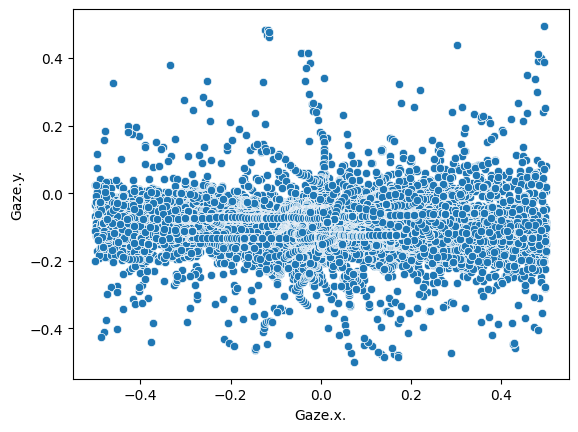

In [34]:
gaze_data = dataset[['Gaze.x.', 'Gaze.y.', 'Ang_Pos', 'Subject', 'Lap_Number']]
gaze_data['Gaze.x.'] = gaze_data['Gaze.x.'] / DISPLAY_X - 0.5
gaze_data['Gaze.y.'] = gaze_data['Gaze.y.'] / DISPLAY_Y - 0.5
# gaze_data['Ang_Pos'] = (gaze_data['Ang_Pos'] / 360 - 0.5) * np.pi 

sns.scatterplot(x=gaze_data['Gaze.x.'], y=gaze_data['Gaze.y.'])

In [44]:
laps = np.unique(gaze_data['Lap_Number'])
subject1_lap0 = gaze_data[(gaze_data['Subject'] == 1) & (gaze_data['Lap_Number'] == 0)]
subject1_lap1 = gaze_data[(gaze_data['Subject'] == 1) & (gaze_data['Lap_Number'] == 1)]

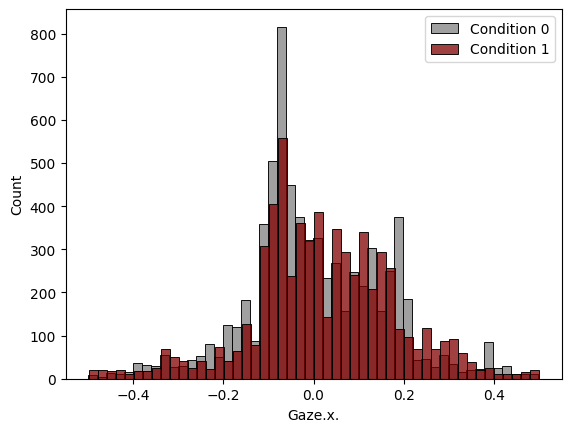

In [45]:
sns.histplot(subject1_lap0['Gaze.x.'], bins=50, color="gray")
sns.histplot(subject1_lap1['Gaze.x.'], bins=50, color="maroon")
plt.legend(['Condition 0', 'Condition 1'])

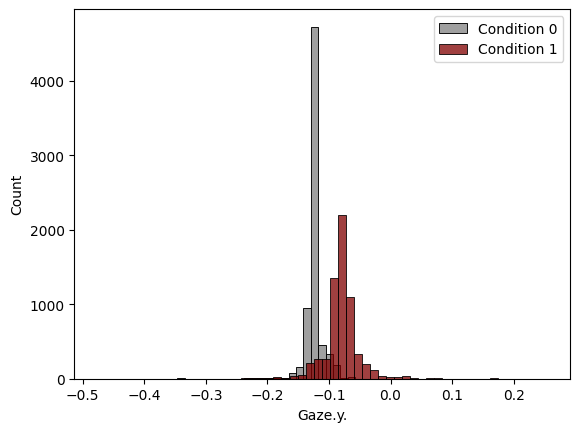

In [46]:
sns.histplot(subject1_lap0['Gaze.y.'], bins=50, color="gray")
sns.histplot(subject1_lap1['Gaze.y.'], bins=50, color="maroon")
plt.legend(['Condition 0', 'Condition 1'])

<Axes: xlabel='Gaze.x.', ylabel='Count'>

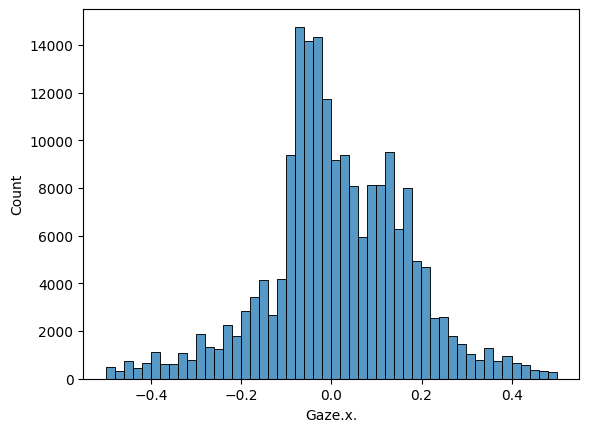

In [37]:
sns.histplot(gaze_data['Gaze.x.'], bins=50)

<Axes: xlabel='Gaze.x.', ylabel='Gaze.y.'>

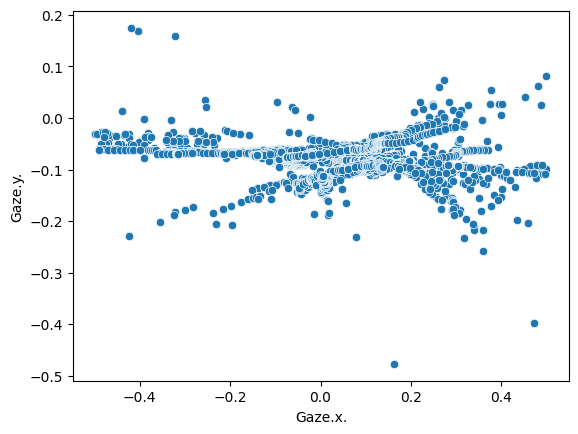

In [48]:
sns.scatterplot(x=subject1_lap1['Gaze.x.'], y=subject1_lap1['Gaze.y.'])

In [27]:
def plot_gaze_by_axis(param, bins=50, xlim=0.5):
    f, axs = plt.subplots(4, 4, figsize=(14, 10))

    for i in range(len(subjects)):
        j, k = int(np.floor(i/4)), i%4
        subject_data = gaze_data[gaze_data['Subject'] == (i + 1)]
        subject_gaze = subject_data[param].to_numpy()
        sns.histplot(subject_gaze, bins=bins, ax=axs[j, k], color="maroon")
        axs[j, k].set_title('Subject {id}'.format(id = i + 1))
        axs[j, k].set_xlabel(param)
        axs[j, k].set_xlim(-xlim, xlim)

    axs.flat[len(subjects)] = sns.histplot(gaze_data[param].to_numpy(), bins=bins, color="#002A3A")
    axs.flat[len(subjects)].set_title('All Subjects')
    axs.flat[len(subjects)].set_xlabel(param)
    axs.flat[len(subjects)].set_xlim(-xlim, xlim)
    plt.tight_layout()

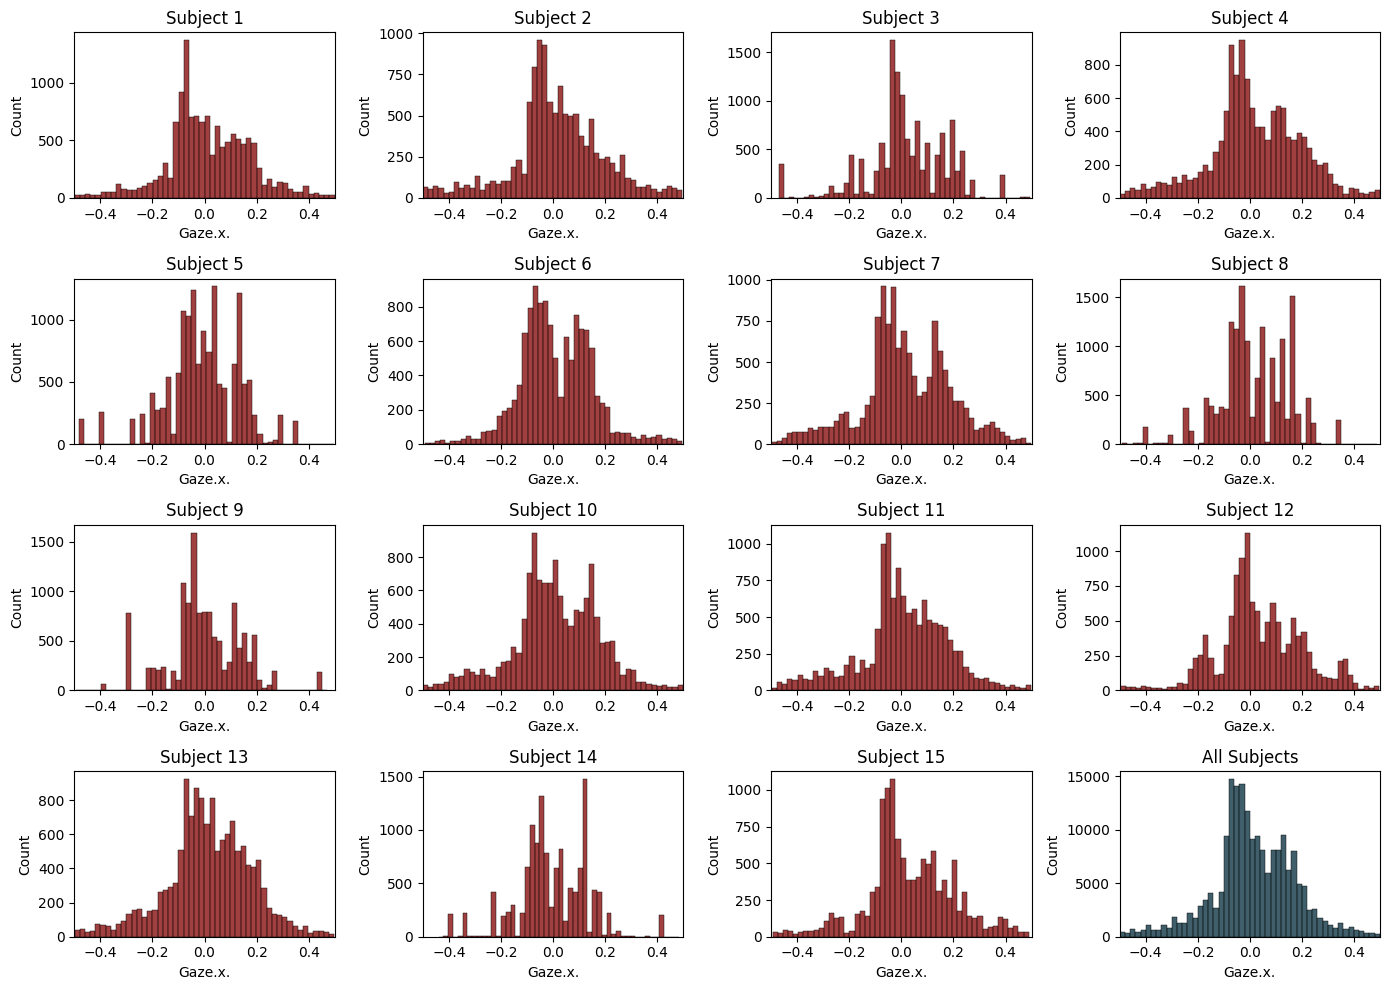

In [28]:
plot_gaze_by_axis('Gaze.x.', bins=50)

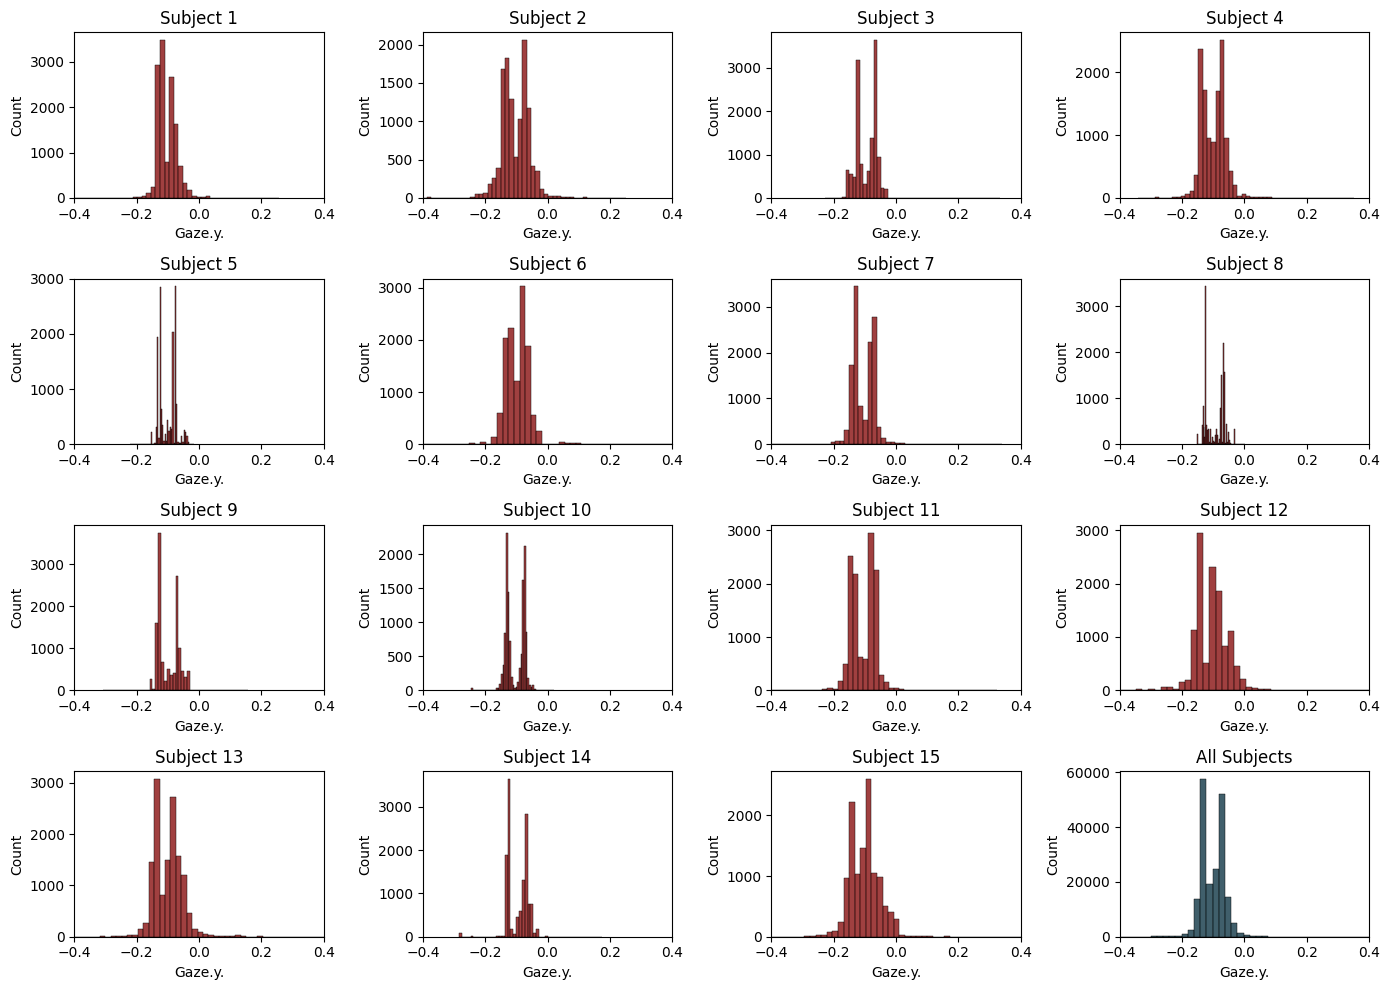

In [29]:
plot_gaze_by_axis('Gaze.y.', bins=50, xlim=0.4)

In [25]:
def plot_gaze_by_angles(param, bins=50, xlim=[-10, 80]):
    f, axs = plt.subplots(4, 4, figsize=(14, 10))

    for i in range(len(subjects)):
        j, k = int(np.floor(i/4)), i%4
        subject_data = gaze_data[gaze_data['Subject'] == (i + 1)]
        subject_gaze = subject_data[param].to_numpy()
        sns.histplot(subject_gaze, bins=bins, ax=axs[j, k], color="maroon")
        axs[j, k].set_title('Subject {id}'.format(id = i + 1))
        axs[j, k].set_xlabel(param)
        axs[j, k].set_xlim(xlim[0], xlim[1])

    axs.flat[len(subjects)] = sns.histplot(gaze_data[param].to_numpy(), bins=bins, color="#002A3A")
    axs.flat[len(subjects)].set_title('All Subjects')
    axs.flat[len(subjects)].set_xlabel(param)
    axs.flat[len(subjects)].set_xlim(xlim[0], xlim[1])
    plt.tight_layout()

Interestingly, the gaze data from both x- and y-axis exhibits the mixture-distributed characteristics.

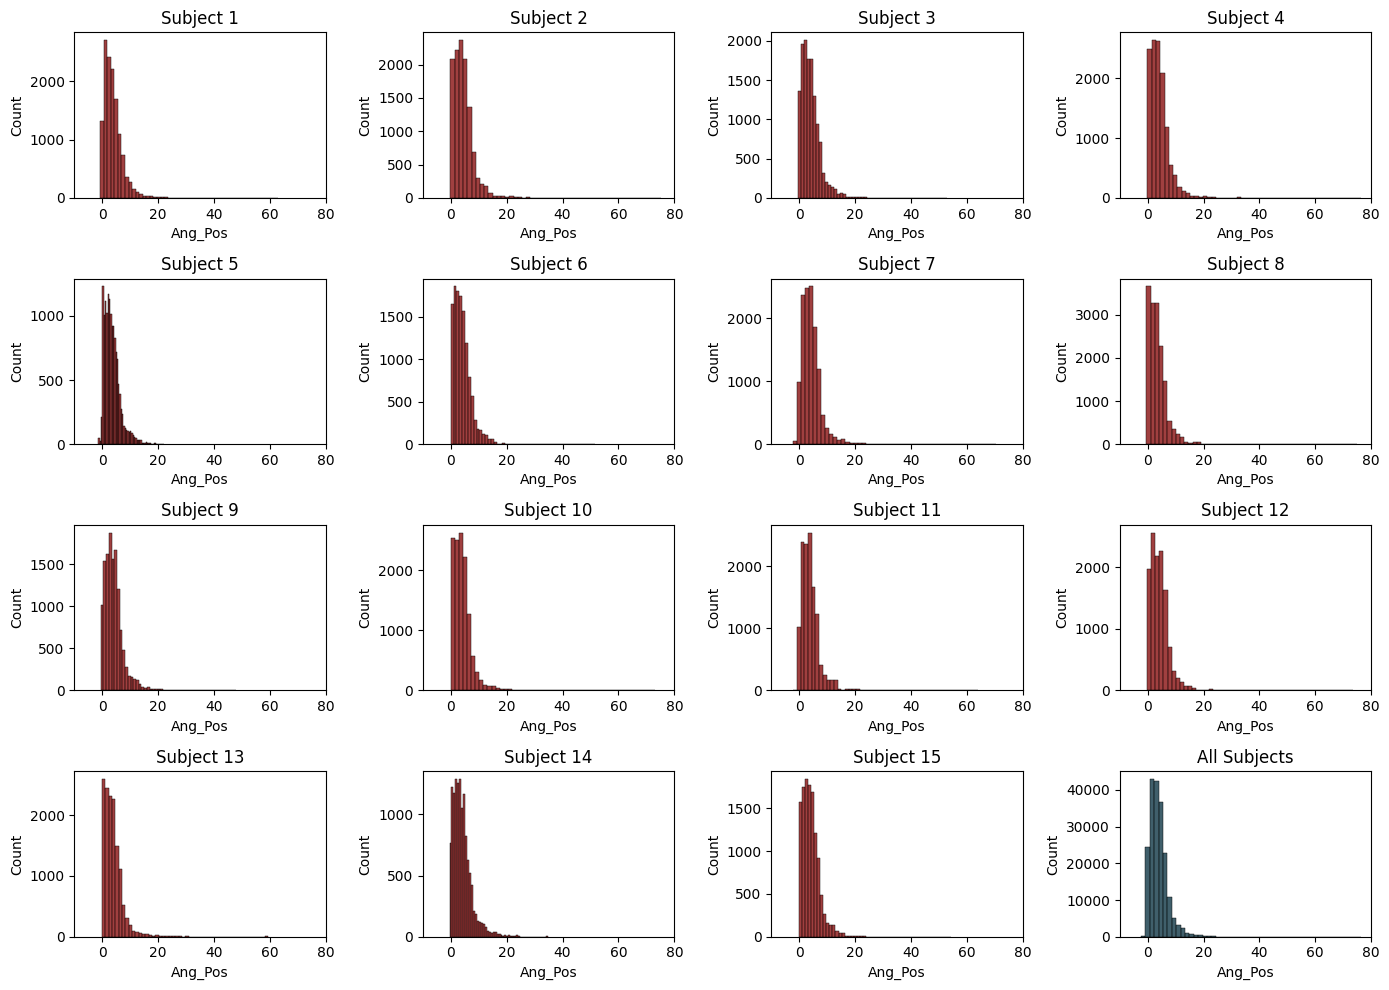

In [26]:
plot_gaze_by_angles('Ang_Pos')

<Axes: xlabel='Ang_Pos', ylabel='Gaze.x.'>

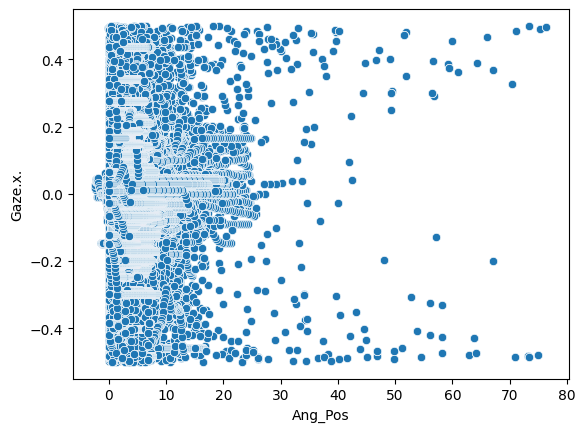

In [19]:
sns.scatterplot(x=gaze_data['Ang_Pos'], y=gaze_data['Gaze.x.'])

<Axes: xlabel='Ang_Pos', ylabel='Gaze.x.'>

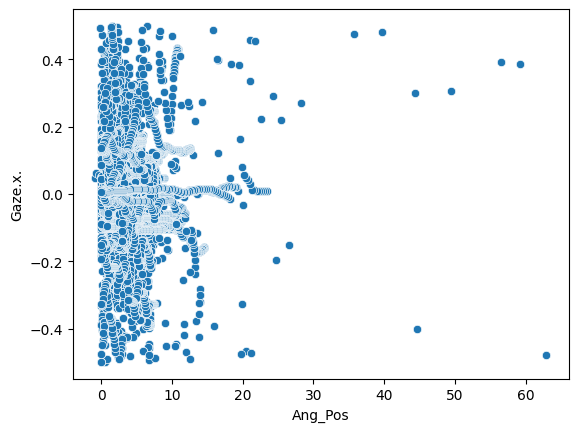

In [20]:
subject_1_data = gaze_data[gaze_data['Subject'] == 1]
sns.scatterplot(x=subject_1_data['Ang_Pos'], y=subject_1_data['Gaze.x.'])

## Simulation

Making a brute-force simulation to make sure that this is not stupid.

In [88]:
RNG = np.random.default_rng(2069)

In [114]:
w = 0.3
offset = 0.2
N_OBS = 10000
W_OBS = np.int16(N_OBS * w)
x = RNG.standard_cauchy(size=N_OBS)
# x = np.concatenate([x1, x2])
y = RNG.normal(0., 0.1, size=N_OBS)

sns.histplot(x)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7efd0bfd5e70>>
Traceback (most recent call last):
  File "/home/geraldwong/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


## Model formulation

Both x and y exhibit Gaussian mixture of 2 components each. For each subject $k = 1, ..., K$, the model can be formulated as

\begin{align}
    \eta_{x, k} &\sim \mathcal{N}(0, 1) \\
    \eta_{y, k} &\sim \mathcal{N}(0, 0.01) \\    
    \rho_{x, k}, \rho_{y, k} &\sim \mathrm{Gamma}(2, 2) \\
    \mu_x | k, \mu_y | k &\sim \mathcal{N}(\eta_{k}, \rho_{k}) \\
    \sigma_x | k, \sigma_y | k &\sim \mathrm{Gamma}(2, 2) \\
    \phi_x | k, \phi_y | k &\sim \mathcal{U}(0, 1), \\
    x &\sim \phi_x \mathcal{N}(\mu_{x, 1}, \sigma_{x, 1}) + (1 - \phi_x) \mathcal{N}(\mu_{x, 2}, \sigma_{x, 2}), \\
    y &\sim \phi_y \mathcal{N}(\mu_{y, 1}, \sigma_{y, 1}) + (1 - \phi_y) \mathcal{N}(\mu_{y, 2}, \sigma_{y, 2}).
\end{align}

In [ ]:
# def hyperprior_fun(rng=None):
#     if rng is None:
#         rng = np.random.default_rng()

In [ ]:
def prior_fun(rng=None):
    """
    Generate prior parameters for vertical gaze distribution.
    """
    if rng is None:
        rng = np.random.default_rng()
        

    phi = rng.uniform(0, 1, size=2)
    mu_x = rng.normal()
    sigma = rng.gamma(2, 2)

    theta = np.array([mu, sigma])

    return theta

In [11]:
#Normalize (x,y) to 0-1
gaze_x = dataset['Gaze.x.'] / 2560
gaze_y = dataset['Gaze.y.'] / 1080

gaze_x.max(), gaze_y.max()